In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras import metrics
from keras.callbacks import TensorBoard
from nn_models import *
from IPython.display import HTML
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
HTML('''<script> code_show_err=false;  function code_toggle_err() {if (code_show_err){$('div.output_stderr').hide();} else {$('div.output_stderr').show();}code_show_err = !code_show_err} $( document ).ready(code_toggle_err);</script>To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

Using TensorFlow backend.


In [3]:
window_size = 6
batch_size = 64
data_ = make_clean_data(window_size,batch_size=batch_size,multiplier=1)
time_spent = data_['dataset'].sum(axis=0)/data_['dataset'].sum()*100
print(len(data_['y_train_c']))

/home/asturkmani/Thesis-Old/utils.py:253: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



14592


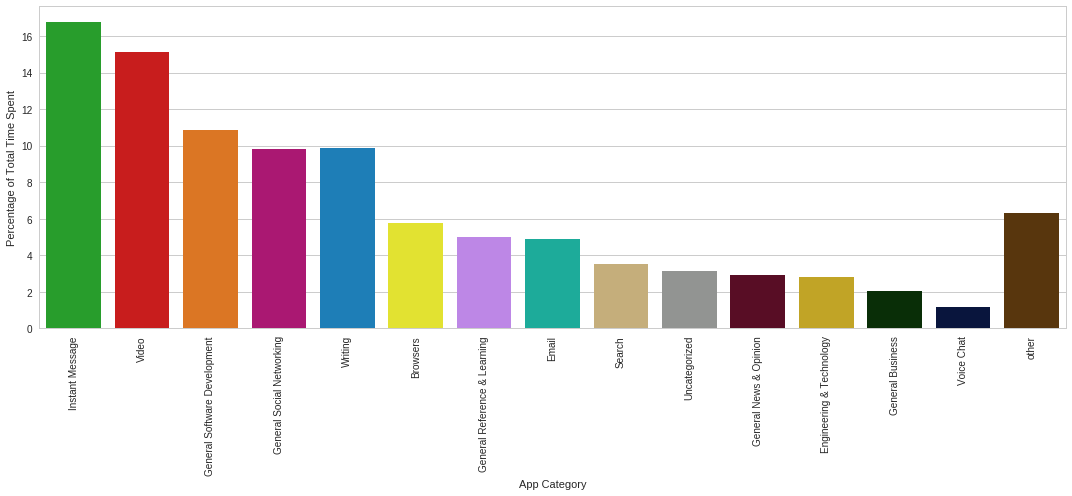

In [5]:
app_colors = ['green','red', 'orange', 'magenta','cerulean', 'yellow', 'light purple', 'turquoise', 'tan', 'grey', 'maroon', 'gold', 'dark green', 'navy blue', 'brown']
col_list_palette = sns.xkcd_palette(app_colors)
app_stats = pd.DataFrame.from_dict({'app' : data_['popular_apps'],'time_spent' : time_spent.tolist(),'colors' : app_colors})

sns.set_style("whitegrid")
plt.figure(figsize=(15,7))
plt.xticks(rotation=90)
ax = sns.barplot(x='app', y='time_spent', data=app_stats, palette=col_list_palette)
plt.xlabel(s='App Category')
plt.ylabel(s='Percentage of Total Time Spent')
plt.tight_layout()
plt.savefig('TimeSpentDistribution.svg', format='svg', dpi=1200)

In [8]:
original_dim = data_['x_train_c'].shape[-1]

time_dim = data_['time']
days_dim = data_['days']

intermediate_dim = 0
epochs = 100

ld = [2,3,4,5,6,7,8]
losses = list()
for latent_dim in ld
    tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,write_graph=True, write_images=False)
    vae, encoder, generator = build_vae(original_dim=15, 
                                            batch_size=batch_size, 
                                            latent_dim = latent_dim, 
                                            intermediate_dim = 10, 
                                            activ='relu', 
                                            optim='rmsprop', 
                                            epsilon_std=1.)

    vae_hist = vae.fit(x=data_['y_train_c'], y=data_['y_train_c'],verbose = 2,shuffle=False,batch_size=batch_size,epochs=epochs, validation_data = (data_['y_test_c'],data_['y_test_c']),callbacks = [tensorboard, EarlyStopping(patience = 5)])
    losses.append( min(vae_hist.history['val_loss'])

2 3.13304593479
3 3.11824500352
4 3.11149942666
5 3.10955175391
6 3.10219099647
7 3.10346032444
8 3.09457541349


In [1]:
'''This script demonstrates how to build a variational autoencoder with Keras.
Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0


x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)


# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

Using TensorFlow backend.


TypeError: sigmoid_cross_entropy_with_logits() got an unexpected keyword argument 'labels'